# Import dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\Abhishek Garia\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Abhishek Garia\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wan

In [2]:
num_classes=10
input_shape=(32,32,3)

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

print(f"x_train shape:{x_train.shape}- y_train:{y_train.shape}")
print(f"x_test shape:{x_test.shape}- y_test:{y_test.shape}")

x_train shape:(50000, 32, 32, 3)- y_train:(50000, 1)
x_test shape:(10000, 32, 32, 3)- y_test:(10000, 1)


In [3]:
x_train=x_train[:500]
y_train=y_train[:500]
x_test=x_test[:500]
y_test=y_test[:500]

# Hyper parameters

In [4]:
learning_rate=0.001
weight_decay=0.0001
batch_size=256
num_epochs=40
image_size=72    #resizing the input image
patch_size=6     #size of patches to be extracted from the imput layers
num_patches=(image_size//patch_size)**2
projection_dim=64
num_heads=4
transformer_units=[projection_dim*2,projection_dim]     #size of the transformer layer
transformer_layers=8
mlp_head_units=[2048,1024]  #size of the dense layers of the final classifier


# Creating vit classifier

data augmentation

In [5]:
data_augmentation=keras.Sequential([
    layers.Normalization(),
    layers.Resizing(image_size,image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.2,width_factor=0.2)
],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

mlp architecture

In [6]:
def mlp(x,hidden_units,dropout_rate):
    for units in hidden_units:
        x=layers.Dense(units,activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout_rate)(x)
    return x

patches

In [7]:
class Patches(layers.Layer):
    def __init__(self,patch_size):
        super(Patches,self).__init__()
        self.patch_size=patch_size
        
    def call(self,images):
        batch_size=tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1,self.patch_size,self.patch_size,1],
                                           strides=[1,self.patch_size,self.patch_size,1],
                                           rates=[1,1,1,1],
                                           padding="VALID",
                                          )
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        
        return patches

image size:72 X 72
patch size:6 X 6
patch per image:144
elements per patch:108


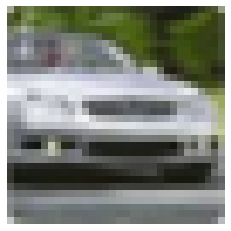

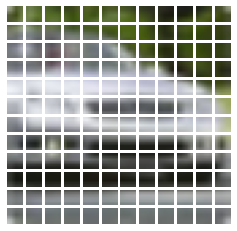

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image=tf.image.resize(tf.convert_to_tensor([image]),size=(image_size,image_size))

patches=Patches(patch_size)(resized_image)
print(f"image size:{image_size} X {image_size}")
print(f"patch size:{patch_size} X {patch_size}")
print(f"patch per image:{patches.shape[1]}")
print(f"elements per patch:{patches.shape[-1]}")

n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch,(patch_size,patch_size,3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self,num_patches,projection_dim):
        super(PatchEncoder,self).__init__()
        self.num_patches=num_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding=layers.Embedding(
            input_dim=num_patches,output_dim=projection_dim
        )
    def call(self,patch):
        positions=tf.range(start=0,limit=self.num_patches,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded

creating vit classifier

In [10]:
def create_vit_classifier():
    inputs=layers.Input(shape=input_shape)
    augmented=data_augmentation(inputs)#augmentation
    patches=Patches(patch_size)(augmented)#create patches
    encoded_patches=PatchEncoder(num_patches,projection_dim)(patches)#encode pathces
    
    
    #create multiple layers for transformer block
    for _ in range(transformer_layers):
        #layer normalization1
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        #create multihead attention layer
        attention_output=layers.MultiHeadAttention(
            num_heads=num_heads,key_dim=projection_dim,dropout=0.1
        )(x1,x1)
    
        #skip connecton1
        x2=layers.Add()([attention_output,encoded_patches])
        
        #layer normalization
        x3=layers.LayerNormalization(epsilon=1e-6)(x2)
        
        #mlp
        x3=mlp(x3, hidden_units=transformer_units,dropout_rate=0.1)
        
        #skip connection 2
        encoded_patches=layers.Add()([x3,x2])
        
    #create a batchsize and projectiondim tensor
    
    representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation=layers.Flatten()(representation)
    representation=layers.Dropout(0.5)(representation)
    
    #add mlp
    features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
    
    #classify outputs
    logits=layers.Dense(num_classes)(features)
    
    #create keras model
    
    model=keras.Model(inputs=inputs,outputs=logits)
    return model

# Training the model

In [11]:
def run_experiment(model):
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate,weight_decay=weight_decay
    
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5,name="top_5_accuracy"),
        ],
    )
    
    checkpoint_filepath="./tmp/checkpoint"
    checkpoint_callback=keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weight_only=True,
    )
    
    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    
    
    model.load_weights(checkpoint_filepath)
    _,accuracy,top_5_accuracy=model.evaluate(x_test,y_test)
    print(f"test accuracy:{round(accuracy*100,2)}%")
    print(f"top 5 accuracy:{round(top_5_accuracy*100,2)}%")

In [12]:
vit_classifier=create_vit_classifier()
history=run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - ETA: 0s - loss: 5.9292 - accuracy: 0.1022 - top_5_accuracy: 0.5267 

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


2/2 [==============================] - 36s 17s/step - loss: 5.9292 - accuracy: 0.1022 - top_5_accuracy: 0.5267 - val_loss: 5.5125 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.5600
Epoch 2/40
2/2 [==============================] - ETA: 0s - loss: 5.7494 - accuracy: 0.1867 - top_5_accuracy: 0.6467

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


2/2 [==============================] - 22s 16s/step - loss: 5.7494 - accuracy: 0.1867 - top_5_accuracy: 0.6467 - val_loss: 3.6988 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.5800
Epoch 3/40
2/2 [==============================] - 14s 7s/step - loss: 4.3187 - accuracy: 0.2267 - top_5_accuracy: 0.6733 - val_loss: 2.4394 - val_accuracy: 0.1600 - val_top_5_accuracy: 0.6800
Epoch 4/40
2/2 [==============================] - 14s 6s/step - loss: 3.0905 - accuracy: 0.2156 - top_5_accuracy: 0.7089 - val_loss: 2.4017 - val_accuracy: 0.1600 - val_top_5_accuracy: 0.6200
Epoch 5/40
2/2 [==============================] - 13s 6s/step - loss: 2.7293 - accuracy: 0.1978 - top_5_accuracy: 0.6956 - val_loss: 2.1241 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.6800
Epoch 6/40
2/2 [==============================] - 13s 6s/step - loss: 2.4190 - accuracy: 0.2356 - top_5_accuracy: 0.7133 - val_loss: 2.0519 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.7800
Epoch 7/40
2/2 [==============================] - 

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


2/2 [==============================] - 25s 18s/step - loss: 1.9524 - accuracy: 0.3400 - top_5_accuracy: 0.8422 - val_loss: 1.8173 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8400
Epoch 11/40
2/2 [==============================] - 14s 6s/step - loss: 2.1030 - accuracy: 0.2956 - top_5_accuracy: 0.7867 - val_loss: 1.8361 - val_accuracy: 0.2000 - val_top_5_accuracy: 0.8600
Epoch 12/40
2/2 [==============================] - 14s 6s/step - loss: 1.8504 - accuracy: 0.3600 - top_5_accuracy: 0.8444 - val_loss: 1.8386 - val_accuracy: 0.2200 - val_top_5_accuracy: 0.8600
Epoch 13/40
2/2 [==============================] - 14s 6s/step - loss: 1.8888 - accuracy: 0.3578 - top_5_accuracy: 0.8289 - val_loss: 1.8003 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.8600
Epoch 14/40
2/2 [==============================] - 14s 6s/step - loss: 1.7967 - accuracy: 0.3844 - top_5_accuracy: 0.8622 - val_loss: 1.8403 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8600
Epoch 15/40
2/2 [=============================

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


2/2 [==============================] - 26s 19s/step - loss: 0.9500 - accuracy: 0.7000 - top_5_accuracy: 0.9667 - val_loss: 2.2131 - val_accuracy: 0.3000 - val_top_5_accuracy: 0.8200
Epoch 35/40
2/2 [==============================] - 14s 6s/step - loss: 0.8575 - accuracy: 0.6733 - top_5_accuracy: 0.9822 - val_loss: 2.2237 - val_accuracy: 0.3000 - val_top_5_accuracy: 0.8600
Epoch 36/40
2/2 [==============================] - 14s 6s/step - loss: 0.8779 - accuracy: 0.7044 - top_5_accuracy: 0.9844 - val_loss: 2.2797 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8600
Epoch 37/40
2/2 [==============================] - 14s 6s/step - loss: 0.8119 - accuracy: 0.6911 - top_5_accuracy: 0.9889 - val_loss: 2.4308 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8400
Epoch 38/40
2/2 [==============================] - 14s 6s/step - loss: 0.8455 - accuracy: 0.6867 - top_5_accuracy: 0.9911 - val_loss: 2.4960 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8400
Epoch 39/40
2/2 [=============================

# Evaluation

In [13]:
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [14]:
def image_predict(images,model):
    if len(images.shape)==3:
        out=model.predict(images.reshape(-1,*images.shape))
        
    else:
        out=model.predict(images)
    prediction=np.argmax(out,axis=1)
    img_prediction=[class_names[i] for i in prediction]
    return img_prediction

['dog']


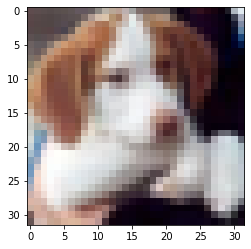

In [26]:
import random


index=random.randint(0, 20)
plt.imshow(x_test[index])
prediction=image_predict(x_test[index],vit_classifier)
print(prediction)